In [418]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 18 14:57:23 2023
"""
dir_ginette = '/home/ariviere/Programmes/ginette'
import sys
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
import fortranformat as ft
import glob
import time
from collections import namedtuple
from dataclasses import dataclass
from random import uniform, gauss
from numpy import inf, nansum, log, size, var, mean, isclose, sqrt, zeros, all
from itertools import product
from typing import Callable, Tuple, Sequence
from pathlib import Path
from scipy.interpolate import interp1d, griddata
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates
import pyvista as pv
import shutil
# Ajouter le chemin du dossier src au PYTHONPATH
import importlib

sys.path.append(dir_ginette)  # Ajouter le dossier parent de src
# use __init__.py to import all functions/ in src/src_gmsh and src/src_pythont
# insure 
from src.src_gmsh import mesh_generator
from src.src_python import Init_folders
from src.src_python import Direct_model
from src.src_python import Read_obs
from src.src_python import Plot
from src.src_python import stat_critere

# Import all functions/classes from the relevant modules
from src.src_gmsh.mesh_generator import *
from src.src_python.Init_folders import *
from src.src_python.Direct_model import *
from src.src_python.Read_obs import *
from src.src_python.Plot import *
from src.src_python.stat_critere import *
import importlib
importlib.reload(mesh_generator)
importlib.reload(Read_obs)
importlib.reload(Plot)
importlib.reload(Init_folders)
importlib.reload(Direct_model)
importlib.reload(mesh_generator)
importlib.reload(stat_critere)
# Ajouter le chemin du dossier src au PYTHONPATH
src_dir=os.path.join(dir_ginette, "src")
sys.path.insert(0, src_dir)
# give me all names of the functions in Init_folders
#print(Init_folders.__dict__)
#print([name for name in dir(Init_folders) if callable(getattr(Init_folders, name)) and not name.startswith("__")])



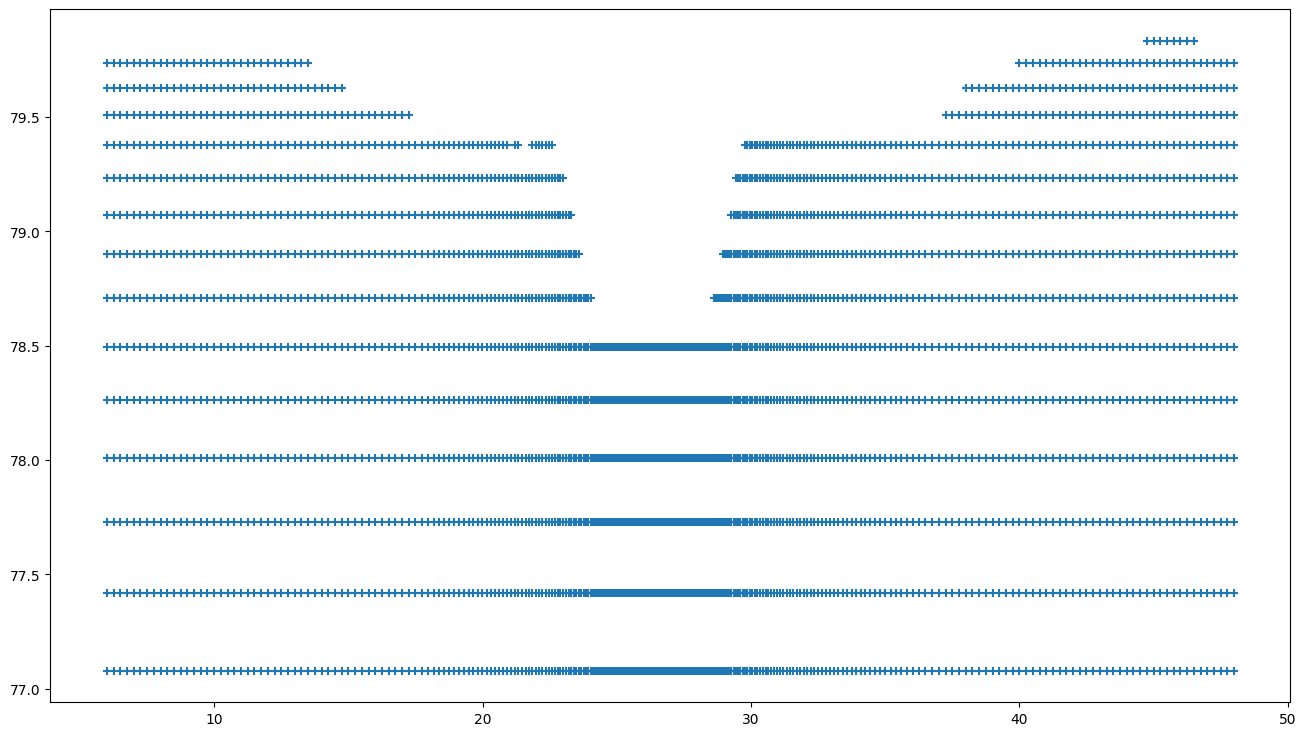

In [419]:
sim_dir = "/home/ariviere/Programmes/ginette/application/2017_AVAV_SENSI"
# read E_coordonnee.dat from file
e_coordinates_path = os.path.join(sim_dir, "E_coordonnee.dat")
coord = pd.read_csv(e_coordinates_path, sep='\s+', header=None, names=["x", "z"])
coord.head()

# interactive corrdinates on the plot
x = coord['x']
z = coord['z']
fig, ax = plt.subplots(figsize = (16,9))

ax.scatter(x,z,marker="+") # Trace le centre de chaque mailles
plt.show()

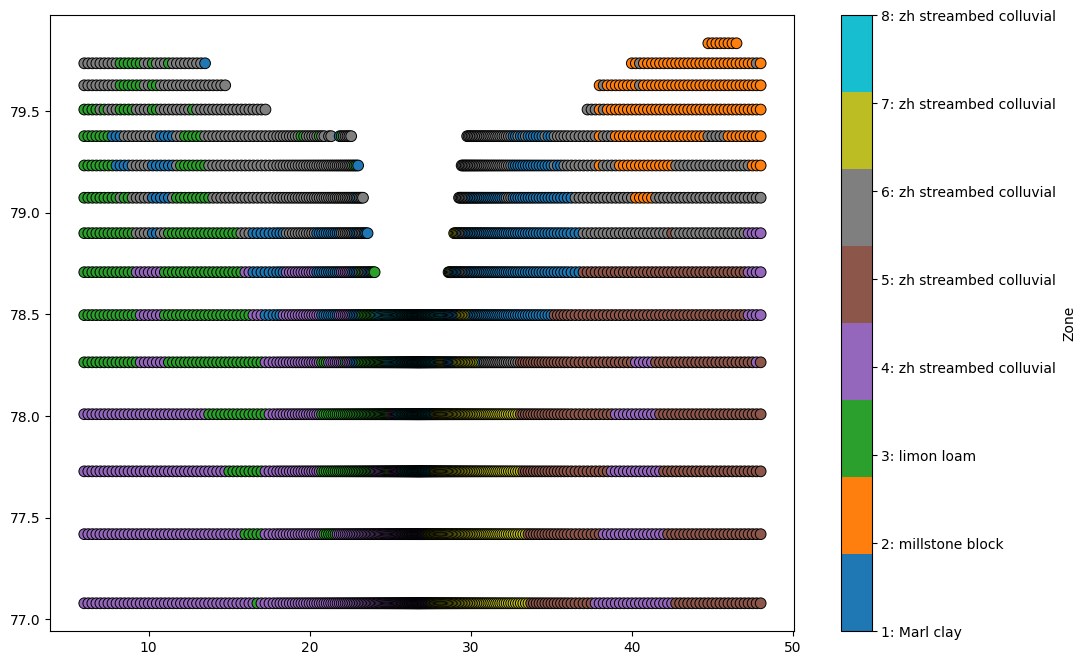

In [420]:
nb_zone=8
# read E_zone.dat 
zone=pd.read_csv(os.path.join(sim_dir, "E_zone.dat"), sep='\s+', header=None, names=["zone"])
# add coord x z
zone['x'] = coord['x']
zone['z'] = coord['z']
# plot color by zone
plt.figure(figsize=(12, 8))
plt.scatter(
        zone['x'], zone['z'],
        c=zone['zone'],
        cmap=plt.get_cmap('tab10', nb_zone),  # Use a colormap with nb_zone discrete colors
        s=60, edgecolor='k', linewidth=0.7, vmin=1, vmax=nb_zone
)
# add legend zone =1 : green clay, zone =2 : millstone block, zone =3 : limon loam, zone =4 : zh streambed colluvial
# Create a colorbar with custom tick labels for zones
cbar = plt.colorbar(ticks=[1, 2, 3, 4,5, 6, 7, 8])
cbar.set_label('Zone')
cbar.set_ticklabels([
    '1: Marl clay',
    '2: millstone block',
    '3: limon loam',
    '4: zh streambed colluvial',
    '5: zh streambed colluvial',
    '6: zh streambed colluvial',
    '7: zh streambed colluvial',
    '8: zh streambed colluvial'
])


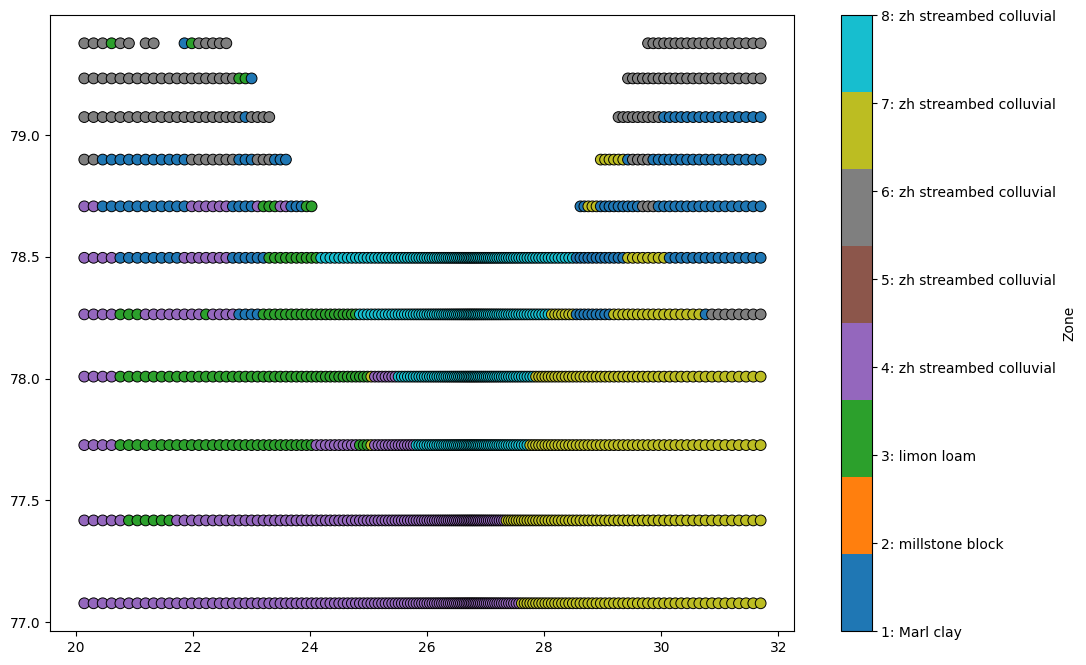

In [421]:
XRG=  20.
XRD=  31.8
# zoom zone
#subset zone
zone_subset = zone[(zone['x'] > XRG) & (zone['x'] < XRD)]
# plot color by zone
plt.figure(figsize=(12, 8))
plt.scatter(
        zone_subset['x'], zone_subset['z'],
        c=zone_subset['zone'],
        cmap=plt.get_cmap('tab10', nb_zone),  # Use a colormap with nb_zone discrete colors
        s=60, edgecolor='k', linewidth=0.7, vmin=1, vmax=nb_zone
)
# add legend zone =1 : green clay, zone =2 : millstone block, zone =3 : limon loam, zone =4 : zh streambed colluvial
# Create a colorbar with custom tick labels for zones
cbar = plt.colorbar(ticks=[1, 2, 3, 4,5, 6, 7, 8])
cbar.set_label('Zone')
cbar.set_ticklabels([
    '1: Marl clay',
    '2: millstone block',
    '3: limon loam',
    '4: zh streambed colluvial',
    '5: zh streambed colluvial',
    '6: zh streambed colluvial',
    '7: zh streambed colluvial',
    '8: zh streambed colluvial'
])


In [422]:
# Configuration du répertoire de travail

file_path = "/home/ariviere/Documents/Bassin_Orgeval/Donnee_Orgeval_Mines/raw_data/DESC_data/DATA_STATION/"  # Chemin vers le fichier CSV
# Ajouter le chemin du dossier src au PYTHONPATH

# Paramètres de du maillage
## name de la station
Station = "AvAv"
# Paramètres sens de la station par rapport à la direction de la rivière
#       |   ↑    |
#  RG   |   ↑    |  RD
#       |        |
#  Rive_D=0 station à l'envers x_piezo_RD=0m dans l'exemple du schema
Rive_D=1
plot=True
dz_pt100=0.15
dz_pt100first=0.1
altitude_min=77
xoffset=-20.3
zoffset=0
# reading the data georef
distance_altitude_table,pt100_coord= process_distance_altitude(file_path, Station, sim_dir, altitude_min, Rive_D,dz_pt100=dz_pt100,dz_pt100first=dz_pt100first)   

Chemin du fichier de nivellement CSV : /home/ariviere/Documents/Bassin_Orgeval/Donnee_Orgeval_Mines/raw_data/DESC_data/DATA_STATION/AvAv/AvAv.csv


/tmp/ipykernel_5428/424460080.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  zone_colors = cm.get_cmap('tab20', len(unique_zones))


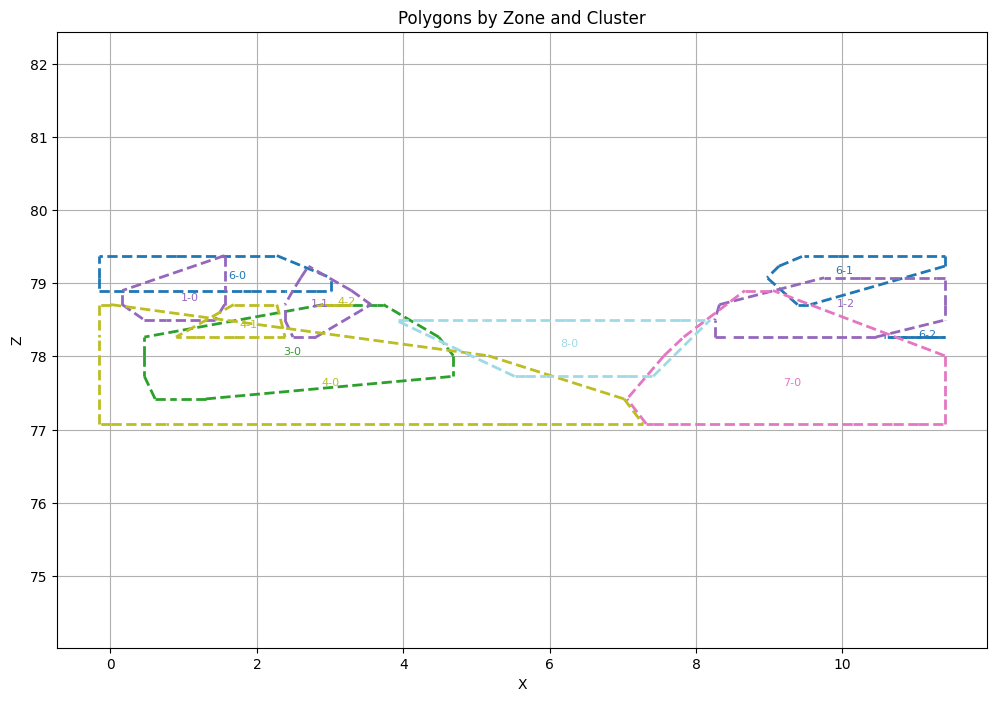

In [423]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull, QhullError
import matplotlib.cm as cm

warnings.filterwarnings("ignore", message="numpy.dtype size changed")

all_zone_polygons = []

# Unique zone list for color assignment
unique_zones = zone_subset["zone"].unique()
zone_colors = cm.get_cmap('tab20', len(unique_zones))

# Plot setup
plt.figure(figsize=(12, 8))

for i, zone_num in enumerate(unique_zones):
    zone_points_df = zone_subset[zone_subset["zone"] == zone_num]
    points = np.column_stack([
        zone_points_df["x"] + xoffset,
        zone_points_df["z"] + zoffset
    ])

    if len(points) >= 3:
        clustering = DBSCAN(eps=0.5, min_samples=3).fit(points)
        labels = clustering.labels_

        for cluster_id in set(labels):
            if cluster_id == -1:
                continue  # Skip noise

            cluster_points = points[labels == cluster_id]

            if len(cluster_points) >= 1:
                try:
                    hull = ConvexHull(cluster_points, qhull_options='QJ')
                    polygon = cluster_points[hull.vertices]

                    # Save polygon data
                    all_zone_polygons.append({
                        "zone": zone_num,
                        "cluster": int(cluster_id),
                        "polygon": polygon.tolist()
                    })

                    # Plot with zone-specific color
                    color = zone_colors(i)
                    for simplex in hull.simplices:
                        plt.plot(
                            cluster_points[simplex, 0],
                            cluster_points[simplex, 1],
                            color=color,
                            linestyle='--', lw=2
                        )

                    # Optional: label cluster
                    centroid = np.mean(polygon, axis=0)
                    plt.text(centroid[0], centroid[1], f"{zone_num}-{cluster_id}",
                             fontsize=8, color=color)

                except QhullError:
                    print(f"Skipping degenerate cluster in zone {zone_num}, cluster {cluster_id}")

            # extract the coordinates of the polygon
            

plt.axis('equal')
plt.title("Polygons by Zone and Cluster")
plt.xlabel("X")
plt.ylabel("Z")
plt.grid(True)
plt.show()


/tmp/ipykernel_5428/4245480854.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  zone_colors = cm.get_cmap('tab20', len(unique_zones))


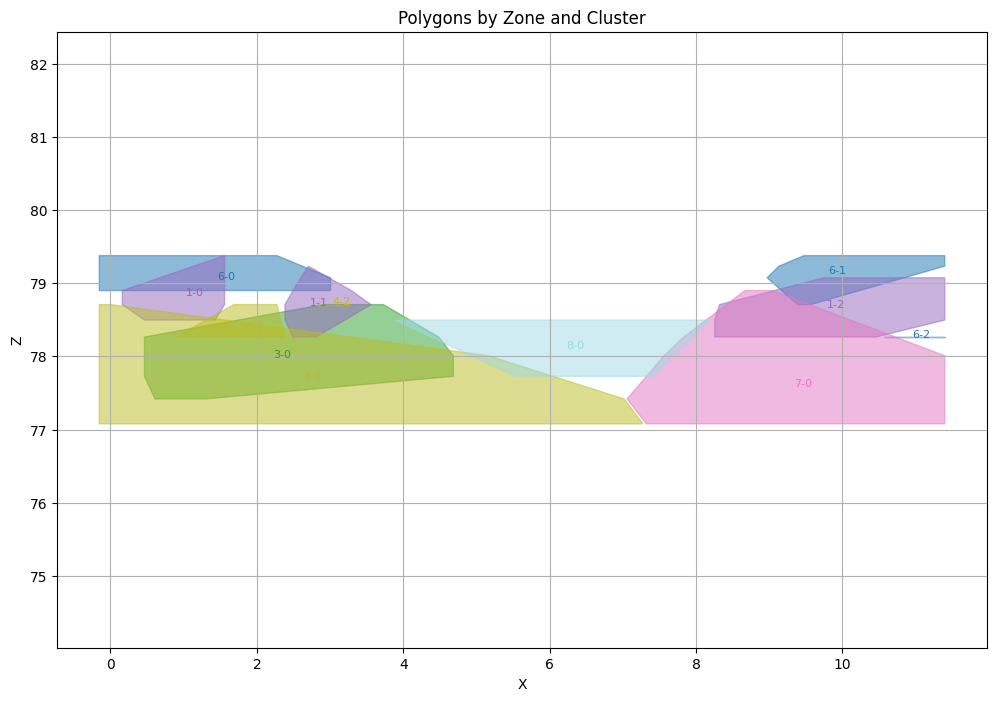

In [424]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull, QhullError
import matplotlib.cm as cm

warnings.filterwarnings("ignore", message="numpy.dtype size changed")

all_zone_polygons = []

# Unique zone list for color assignment
unique_zones = zone_subset["zone"].unique()
zone_colors = cm.get_cmap('tab20', len(unique_zones))

# Plot setup
plt.figure(figsize=(12, 8))

for i, zone_num in enumerate(unique_zones):
    zone_points_df = zone_subset[zone_subset["zone"] == zone_num]
    points = np.column_stack([
        zone_points_df["x"] + xoffset,
        zone_points_df["z"] + zoffset
    ])

    if len(points) >= 3:
        clustering = DBSCAN(eps=0.5, min_samples=3).fit(points)
        labels = clustering.labels_

        for cluster_id in set(labels):
            if cluster_id == -1:
                continue  # Skip noise

            cluster_points = points[labels == cluster_id]

            if len(cluster_points) >= 1:
                try:
                    hull = ConvexHull(cluster_points, qhull_options='QJ')
                    polygon = cluster_points[hull.vertices]

                    # Ensure the polygon is closed
                    polygon = np.append(polygon, [polygon[0]], axis=0)

                    # Save polygon data
                    all_zone_polygons.append({
                        "zone": zone_num,
                        "cluster": int(cluster_id),
                        "polygon": polygon.tolist()
                    })

                    # Plot filled polygon with zone-specific color
                    color = zone_colors(i)
                    plt.fill(
                        polygon[:, 0],
                        polygon[:, 1],
                        color=color,
                        alpha=0.5  # Use transparency to visualize overlaps
                    )

                    # Optional: label cluster
                    centroid = np.mean(polygon, axis=0)
                    plt.text(centroid[0], centroid[1], f"{zone_num}-{cluster_id}",
                             fontsize=8, color=color)

                except QhullError:
                    print(f"Skipping degenerate cluster in zone {zone_num}, cluster {cluster_id}")

plt.axis('equal')
plt.title("Polygons by Zone and Cluster")
plt.xlabel("X")
plt.ylabel("Z")
plt.grid(True)
plt.show()


In [425]:
# Extract the coordinates of each polygon from all_zone_polygons
polygon_coords = []
for poly in all_zone_polygons:
    coords = np.array(poly["polygon"])
    polygon_coords.append({
        "zone": poly["zone"],
        "cluster": poly["cluster"],
        "coordinates": coords
    })
nu=3
if polygon_coords:
    print("First polygon coordinates (zone, cluster):", polygon_coords[nu]["zone"], polygon_coords[nu]["cluster"])
    print(polygon_coords[nu]["coordinates"])


First polygon coordinates (zone, cluster): 3 0
[[ 0.60977 77.41807]
 [ 0.89434 77.41807]
 [ 1.30062 77.41807]
 [ 4.68434 77.72715]
 [ 4.68434 78.00813]
 [ 4.48517 78.26356]
 [ 3.72896 78.70688]
 [ 3.64478 78.70688]
 [ 2.90776 78.70688]
 [ 0.4632  78.26356]
 [ 0.4632  78.00813]
 [ 0.4632  77.72715]
 [ 0.60977 77.41807]]


In [533]:
# Extract the coordinates of each polygon from all_zone_polygons
polygon_coords = []
for poly in all_zone_polygons:
    coords = np.array(poly["polygon"])
    polygon_coords.append({
        "zone": poly["zone"],
        "cluster": poly["cluster"],
        "coordinates": coords
    })


def modify_polygon_z(poly_coords, old_z, new_z, tol=1e-5):
    # Ensure poly_coords is a NumPy array
    coords = np.array(poly_coords)

    # Check if the array is not empty and has at least two columns
    if coords.size == 0 or coords.shape[1] < 2:
        return coords

    # Find indices where the z-coordinate is close to old_z
    idx = np.where(np.isclose(coords[:, 1], old_z, atol=tol))[0]

    # Modify the z-coordinate for all found indices
    if len(idx) > 0:
        coords[idx, 1] = new_z

    return coords

def modify_polygon_x(poly_coords, old_x, new_x, tol=1e-5):
    # Ensure poly_coords is a NumPy array
    coords = np.array(poly_coords)

    # Check if the array is not empty and has at least two columns
    if coords.size == 0 or coords.shape[1] < 2:
        return coords

    # Find indices where the z-coordinate is close to old_z
    idx = np.where(np.isclose(coords[:, 0], old_x, atol=tol))[0]

    # Modify the z-coordinate for all found indices
    if len(idx) > 0:
        coords[idx, 0] = new_x

    return coords
#__________________________________________________
# replace a point
def modify_polygon_xandz(poly_coords, old_point, new_point, tol=1e-5):
    """
    Replace a point in a polygon's coordinates with a new point (within tolerance).

    Parameters:
    - poly_coords: List or array of coordinates representing the polygon.
    - old_point: List or array [old_x, old_z] to match.
    - new_point: List or array [new_x, new_z] to set.
    - tol: Tolerance for floating-point comparison.

    Returns:
    - Updated NumPy array of polygon coordinates.
    """
    coords = np.array(poly_coords)
    if coords.size == 0 or coords.shape[1] < 2:
        return coords

    # Find indices where both x and z are close to old_point
    idx = np.where(
        (np.isclose(coords[:, 0], old_point[0], atol=tol)) &
        (np.isclose(coords[:, 1], old_point[1], atol=tol))
    )[0]

    if len(idx) > 0:
        coords[idx[0]] = new_point  # Replace the first match

    return coords
#__________________________________________________
# replace a point by imposing the index (posi)
def modify_polygon_xandz_posi(poly_coords, new_point, posi, tol=1e-5):
    """
    Replace a point in a polygon's coordinates at a specific index with a new point.

    Parameters:
    - poly_coords: List or array of coordinates representing the polygon.
    - new_point: List or array [new_x, new_z] to set.
    - posi: Index at which to replace the point.
    - tol: (Unused, kept for compatibility)

    Returns:
    - Updated NumPy array of polygon coordinates.
    """
    coords = np.array(poly_coords)
    if coords.size == 0 or coords.shape[1] < 2:
        return coords

    if 0 <= posi < len(coords):
        coords[posi] = new_point

    return coords
#__________________________________________________

def add_point_to_polygon(poly_coords, new_point):
    """
    Add a point to a polygon's coordinates.

    Parameters:
    - poly_coords: List of coordinates representing the polygon.
    - new_point: The new point to add to the polygon.

    Returns:
    - Updated NumPy array of polygon coordinates.
    """
    coords = np.array(poly_coords)

    # Use np.vstack to add the new point
    coords = np.vstack([coords, new_point])

    return coords
def add_point_after(poly_coords, target_point, new_point):
    """
    Add a point after a specific point in a polygon's coordinates.

    Parameters:
    - poly_coords: NumPy array of coordinates representing the polygon.
    - target_point: The point after which the new point will be added.
    - new_point: The new point to add to the polygon.

    Returns:
    - Updated NumPy array of polygon coordinates.
    """
    coords = np.array(poly_coords)

    # Find the index of the target point with a tolerance for floating-point comparison
    idx = np.where(np.isclose(coords, target_point, atol=1e-5).all(axis=1))[0]

    if len(idx) > 0:
        # Insert the new point after the target point
        coords = np.insert(coords, idx[0] + 1, new_point, axis=0)
    else:
        print("Target point not found in the polygon coordinates.")

    return coords


  
polygon_coords[0]["coordinates"] = modify_polygon_z(polygon_coords[0]["coordinates"], 79.37605, 79.5)
new_point = [-0.15299 ,78.89879]  # Example new point

polygon_coords[0]["coordinates"] = add_point_to_polygon(polygon_coords[0]["coordinates"], new_point)

new_point1=[ 8.97146 ,79.07326]
polygon_coords[1]["coordinates"] = add_point_to_polygon(polygon_coords[1]["coordinates"], new_point1)
new_point1=[9.6,79.1]
target_point =  [ 9.56452 ,78.70688]
polygon_coords[1]["coordinates"] = add_point_after(polygon_coords[1]["coordinates"], target_point,new_point1)
polygon_coords[1]["coordinates"] = modify_polygon_z(polygon_coords[1]["coordinates"], 79.37605, 79.6)

polygon_coords[2]["coordinates"] = modify_polygon_z(polygon_coords[2]["coordinates"],  78.26356, 78.4)
target_point=  [11.39834, 78.4]
# Sort the coordinates of the third polygon by x-coordinate
if len(polygon_coords) > 2:
    polygon_coords[2]["coordinates"] = polygon_coords[2]["coordinates"][np.argsort(polygon_coords[2]["coordinates"][:, 0])]
new_points2 =  [
    [11.39834, 78.1],
    [11.27254, 78.1],
    [11.14921, 78.1],
    [10.79355, 78.1],
    [10.56791, 78.1   ],
    [10.56791, 78.4    ]
]

# Add each new point after the current target point in the third polygon
for new_point in new_points2:
    polygon_coords[2]["coordinates"] = add_point_after(polygon_coords[2]["coordinates"], target_point, new_point)
    # Update the target point to the newly inserted point
    target_point = new_point
# Example: print the first polygon's coordinates
u=3
target_point =   [1.30062 ,77.41807]
new_point1=[ 4.38517 ,77.7271]
polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point,new_point1)
new_point1=[ 4.48517 ,77.9]
polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point,new_point1)

new_point1=[ 4.2 ,77.9]
polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point,new_point1)
new_point1=[ 3.8 ,77.9]
polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point,new_point1)
new_point1=[ 3.8 ,77.6]
polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point,new_point1)
new_point1=[ 1.3 ,77.6]
polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point,new_point1)
target_point = [ 2.90776 ,78.70688]
new_point1=[ 0.8 ,78.35]
polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point,new_point1)
new_point1=[ 0.8 ,78.1]
polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point,new_point1)
new_point1=[ 2.90776 ,78.1]
polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point,new_point1)

polygon_coords[u]["coordinates"] = modify_polygon_z(polygon_coords[u]["coordinates"], 77.7271, 77.6)
polygon_coords[u]["coordinates"] = modify_polygon_z(polygon_coords[u]["coordinates"], 77.41807, 77.25)
polygon_coords[u]["coordinates"] = modify_polygon_z(polygon_coords[u]["coordinates"], 78.70688,78.75)
polygon_coords[u]["coordinates"] = modify_polygon_z(polygon_coords[u]["coordinates"],78.26356,78.35)
polygon_coords[u]["coordinates"] = modify_polygon_x(polygon_coords[u]["coordinates"],3.72896,3.1)
polygon_coords[u]["coordinates"] = modify_polygon_x(polygon_coords[u]["coordinates"],3.64478,2.91)

target_point =    [ 4.48517 ,78.35   ]
new_point1=[ 3.1 ,78.6]
polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point,new_point1)
target_point =    [ 4.48517 ,78.35   ]
new_point1=[ 3.6 ,78.6]
polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point,new_point1)
new_point1=[ 3.6 ,79]
polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point,new_point1)
new_point1=[ 3.8 ,79]
polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point,new_point1)
new_point1=[ 3.8 ,78.35]
polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point,new_point1)

u=4
polygon_coords[u]["coordinates"] = modify_polygon_z(polygon_coords[u]["coordinates"], 79.37605, 78.89879)
polygon_coords[u]["coordinates"] = modify_polygon_z(polygon_coords[u]["coordinates"], 78.49578,78.35)
polygon_coords[u]["coordinates"] = modify_polygon_x(polygon_coords[u]["coordinates"], 0.16121,0)
u=5
target_point =     [ 3.55891 ,78.70688]
new_point1=[ 3. ,79.3]
polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point,new_point1)
new_point1=[ 3.6 ,79.3]
polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point,new_point1)
polygon_coords[u]["coordinates"] = modify_polygon_z(polygon_coords[u]["coordinates"], 79.23186, 79.07326)
polygon_coords[u]["coordinates"] = modify_polygon_z(polygon_coords[u]["coordinates"], 79.07326,78.9)
polygon_coords[u]["coordinates"] = modify_polygon_x(polygon_coords[u]["coordinates"], 3.29085,3.)
polygon_coords[u]["coordinates"] = modify_polygon_x(polygon_coords[u]["coordinates"], 3.55891,3.6)
polygon_coords[u]["coordinates"] = modify_polygon_z(polygon_coords[u]["coordinates"], 78.70688,78.6)
target_point =    [ 2.80715 ,78.26356]
new_point2=[[ 2.91 ,   78.75   ],
 [ 3.1    , 78.75   ],
 [ 3.1  ,   78.6    ]]
for new_point in new_point2:
    polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point, new_point)
    # Update the target point to the newly inserted point
    target_point = new_point
polygon_coords[u]["coordinates"] = modify_polygon_x(polygon_coords[u]["coordinates"],  2.80715,2.91)


u=6
target_point=   [ 9.74963,79.07326]
new_point2=[ [ 9.56452, 78.70688],
 [ 9.38661, 78.70688],[ 8.97146 ,79.07326],[ 8.97146 ,79.07326]
]
for new_point in new_point2:
    polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point, new_point)
    # Update the target point to the newly inserted point
    target_point = new_point
target_point=[ 8.45516 ,78.26356]
new_point2=[  [8.45 ,78.1    ],[8.9 ,78.1    ],[8.9 ,78.4    ],[9.1 ,78.4    ],[9.1 ,78.6    ],[9.8 ,78.6    ],[9.8 ,78.4    ],[10.4 ,78.4    ]
]
for new_point in new_point2:
    polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point, new_point)
    # Update the target point to the newly inserted point
    target_point = new_point
target_point= [10.45839 ,78.26356]
new_point2=[   [10.56791,78.26356   ] ,[10.56791, 78.4    ]]
for new_point in new_point2:
    polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point, new_point)
    # Update the target point to the newly inserted point
    target_point = new_point
oldpoint= [11.39834,79.07326]
new_point1= [11.39834 ,79.23186 ]
polygon_coords[u]["coordinates"] = modify_polygon_xandz(polygon_coords[u]["coordinates"], oldpoint, new_point1)
oldpoint=  [11.27254 ,79.07326]
new_point1= [11.27254 ,79.23186 ]
polygon_coords[u]["coordinates"] = modify_polygon_xandz(polygon_coords[u]["coordinates"], oldpoint, new_point1)
oldpoint=   [10.24577, 79.07326]
new_point1= [10.24577 ,79.15 ]
polygon_coords[u]["coordinates"] = modify_polygon_xandz(polygon_coords[u]["coordinates"], oldpoint, new_point1)
polygon_coords[u]["coordinates"] = modify_polygon_x(polygon_coords[u]["coordinates"],9.74963,9.5)
polygon_coords[u]["coordinates"] = modify_polygon_z(polygon_coords[u]["coordinates"], 78.49578, 78.4)

u=7
target_point=  [11.39834, 78.00813]
new_point2=[   [11.39834,78.1    ],[10.56791 ,78.1   ] ,[10.56791 ,78.26356  ],[10.45 ,78.26356  ],[10.4,78.4  ],[9.8 ,78.4    ],[9.8 ,78.6    ],[9.1 ,78.6    ],[9.1 ,78.4    ]]
for new_point in new_point2:
    polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point, new_point)
    # Update the target point to the newly inserted point
    target_point = new_point

polygon_coords[u]["coordinates"] = modify_polygon_z(polygon_coords[u]["coordinates"], 78.89879, 78.4)
polygon_coords[u]["coordinates"] = modify_polygon_z(polygon_coords[u]["coordinates"], 77.07809, 77)
polygon_coords[u]["coordinates"] = modify_polygon_x(polygon_coords[u]["coordinates"],  8.6677 , 8.9)
target_point=   [8.9, 78.4    ]
new_point2=[ [ 8.9 , 78.1    ],[ 8.45 , 78.1    ] ,[ 8.45 , 78.26356  ]  ]
for new_point in new_point2:
    polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point, new_point)
    # Update the target point to the newly inserted point
    target_point = new_point









u=11
polygon_coords[u]["coordinates"] = modify_polygon_z(polygon_coords[u]["coordinates"], 78.49578, 79)
polygon_coords[u]["coordinates"] = modify_polygon_x(polygon_coords[u]["coordinates"],  8.19072, 8.6)
oldpoint= [ 7.0578 , 77.72715]
new_point= [ 7.0578  ,77.3]
polygon_coords[u]["coordinates"] = modify_polygon_xandz(polygon_coords[u]["coordinates"], oldpoint, new_point)
oldpoint= [  3.89241 ,79.     ]
new_point= [ 3.8 ,79.  ]
polygon_coords[u]["coordinates"] = modify_polygon_xandz(polygon_coords[u]["coordinates"], oldpoint, new_point)
target_point=   [ 7.414 ,  77.72715]
new_point2=[  [ 7.8 , 78.26356  ] , [8.3 , 78.26356  ], [8.3 , 78.6  ]   ]
for new_point in new_point2:
    polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point, new_point)
    # Update the target point to the newly inserted point
    target_point = new_point
target_point=   [  5.95489, 77.72715]
new_point2=[  [ 6,77.5 ] ,[ 6.8,77.5 ],[ 7,77.3 ]   ]
for new_point in new_point2:
    polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point, new_point)
    # Update the target point to the newly inserted point
    target_point = new_point
target_point=  [ 3.8 ,79.  ]
new_point2=[   [ 3.8   ,  78.35   ],[ 4.48517 ,78.35   ] , [ 4.68434, 78.00813], [ 5.2, 78.00813]  ]
for new_point in new_point2:
    polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point, new_point)
    # Update the target point to the newly inserted point
    target_point = new_point













u=8
polygon_coords[u]["coordinates"] = modify_polygon_x(polygon_coords[u]["coordinates"],  -1.529900e-01 , 0)
polygon_coords[u]["coordinates"] = modify_polygon_z(polygon_coords[u]["coordinates"], 7.707809e+01, 77)
target_point= [7.017110e+00 ,7.741807e+01]
new_point2=[    [ 7.0578 , 77.41807],[ 7.    ,  77.4   ], [ 7. ,     77.5    ], [ 6. ,     77.5    ], [ 5.95489, 77.72715], [ 5.52055 ,77.72715], [ 5.2   ,  78.00813]]
for new_point in new_point2:
    polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point, new_point)
    # Update the target point to the newly inserted point
    target_point = new_point
target_point= [5.161070e+00 ,7.800813e+01]
new_point2=[ [ 4.68434, 78.00813],  [ 4.68434 ,77.6    ], [ 4.38517,77.6    ] ,
             [ 4.48517 ,77.9    ],[4.2,77.9],[3.8,77.9],[3.8,77.9],[3.8,77.6],[1.3,77.6],
             [1.30062,77.25],[0.89434,77.25],[0.60977,77.25],[0.4632,77.6],[0.4632,78.00813],[0.4632,78.35]
]

for new_point in new_point2:
    polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point, new_point)
    # Update the target point to the newly inserted point
    target_point = new_point
oldpoint=[5.660000e-03,7.870688e+01]
new_point= [0.4632,78.35]
polygon_coords[u]["coordinates"] = modify_polygon_xandz(polygon_coords[u]["coordinates"], oldpoint, new_point)
oldpoint= [3.800000e+00, 7.790000e+01]
new_point=[0.4632,78.25]
polygon_coords[u]["coordinates"] = modify_polygon_xandz_posi(polygon_coords[u]["coordinates"], new_point,posi=31)


u=9
polygon_coords[u]["coordinates"] = modify_polygon_z(polygon_coords[u]["coordinates"], 78.70688, 78.9)
polygon_coords[u]["coordinates"] = modify_polygon_z(polygon_coords[u]["coordinates"], 78.26356, 78.1)
polygon_coords[u]["coordinates"] = modify_polygon_x(polygon_coords[u]["coordinates"], 2.2731, 2.5)
polygon_coords[u]["coordinates"] = modify_polygon_x(polygon_coords[u]["coordinates"], 1.68346, 1.6)
polygon_coords[u]["coordinates"] = modify_polygon_x(polygon_coords[u]["coordinates"],  0.89434, 0.8)
polygon_coords[u]["coordinates"] = modify_polygon_xandz(polygon_coords[u]["coordinates"], [ 2.5  ,   78.1    ], [ 2.9,    78.1    ])
polygon_coords[u]["coordinates"] = modify_polygon_xandz(polygon_coords[u]["coordinates"],  [ 2.38418,78.1    ], [ 2.9,   78.26356   ])
polygon_coords[u]["coordinates"] = modify_polygon_xandz(polygon_coords[u]["coordinates"],  [ 2.38418,78.1    ], [ 2.9,    78.26356  ])
target_point= [1.6   ,  78.9   ]
new_point2=[ [ 1.55837,78.89879], [ 1.55837 ,78.70688],[ 1.43077 ,78.35   ], [ 0.8 ,78.35   ]]
for new_point in new_point2:
    polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point, new_point)
    # Update the target point to the newly inserted point
    target_point = new_point
target_point= [ 2.9,    78.26356   ]
new_point2=[  [  2.49308, 78.26356], [ 2.38418 ,78.49578],[ 2.49308,78.89879]]
for new_point in new_point2:
    polygon_coords[u]["coordinates"] = add_point_after(polygon_coords[u]["coordinates"], target_point, new_point)
    # Update the target point to the newly inserted point
    target_point = new_point

# remove polygone 10
polygon_coords.pop(10)

    


# export the polygone to read in other python or jupyter notebook
import json
import os
# Specify the path where you want to save the JSON file
dir = os.path.join(file_path, Station)

import json
import os

def convert_numpy(obj):
    """Recursively convert NumPy types in obj to native Python types."""
    if isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy(v) for v in obj]
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

# Convert before saving
converted_coords = convert_numpy(polygon_coords)

# Save to JSON
output_path = os.path.join(dir, "zone_polygon.json")
with open(output_path, 'w') as f:
    json.dump(converted_coords, f, indent=4)

print(f"Saved polygon data to {output_path}")


# read the json file

# Load JSON data
with open(output_path, 'r') as f:
    loaded_polygons = json.load(f)

# Example: print first polygon info
print(loaded_polygons[0])

Saved polygon data to /home/ariviere/Documents/Bassin_Orgeval/Donnee_Orgeval_Mines/raw_data/DESC_data/DATA_STATION/AvAv/zone_polygon.json
{'zone': 6, 'cluster': 0, 'coordinates': [[-0.15298999999999907, 78.89879], [1.8061100000000003, 78.89879], [1.9263399999999997, 78.89879], [2.3841800000000006, 78.89879], [2.80715, 78.89879], [3.0063999999999993, 78.89879], [3.0063999999999993, 79.07326], [2.2730999999999995, 79.5], [0.8943399999999997, 79.5], [-0.15298999999999907, 79.5], [-0.15298999999999907, 79.07326], [-0.15298999999999907, 78.89879], [-0.15299, 78.89879]]}


/tmp/ipykernel_5428/1190506081.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_polygons)


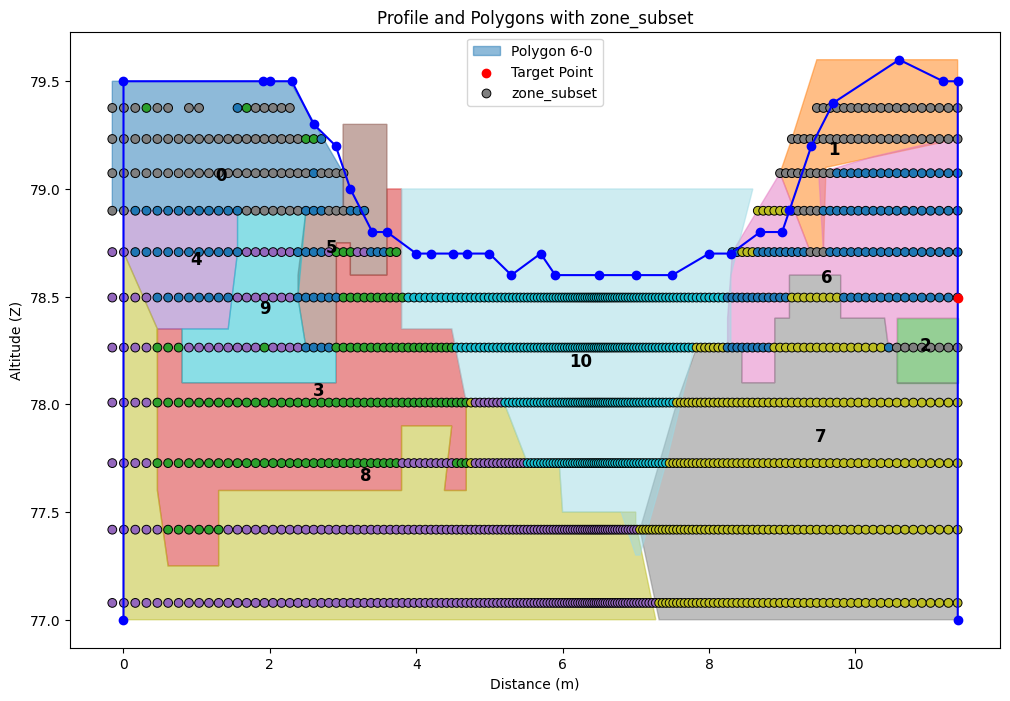

In [534]:
from matplotlib import cm

plt.figure(figsize=(12, 8))
plt.plot(distance_altitude_table["Distance (m)"], distance_altitude_table["Altitude (Z)"], 'o-b')

# Plot filled polygons for the first 6 polygons, each with a different color

num_polygons = 11
cmap = cm.get_cmap('tab20', num_polygons)
for idx, poly in enumerate(polygon_coords[:num_polygons]):
    coords = poly["coordinates"]
    plt.fill(coords[:, 0], coords[:, 1], color=cmap(idx), alpha=0.5, label=f'Polygon {poly["zone"]}-{poly["cluster"]}' if idx == 0 else None)
    # Add the polygon number at its centroid
    centroid = coords.mean(axis=0)
    plt.text(centroid[0], centroid[1], str(idx), fontsize=12, color='black', ha='center', va='center', fontweight='bold')
#plot the point  [ 3.    ,  78.89879]
target=   [11.39834 ,78.49578]
plt.scatter(target[0], target[1], color='red', label='Target Point', zorder=5)
# Plot the zone_subset points colored by zone
plt.scatter(
    zone_subset['x'] + xoffset,
    zone_subset['z'] + zoffset,
    c=zone_subset['zone'],
    cmap=plt.get_cmap('tab10', nb_zone),
    s=40,
    edgecolor='k',
    linewidth=0.7,
    vmin=1,
    vmax=nb_zone,
    label='zone_subset'
)

plt.xlabel("Distance (m)")
plt.ylabel("Altitude (Z)")
plt.title("Profile and Polygons with zone_subset")
plt.legend()
plt.show()


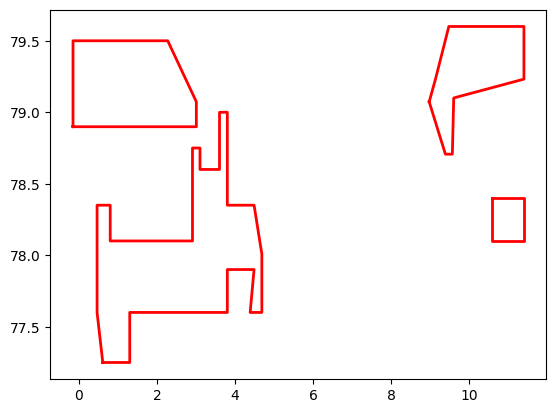

In [535]:
    plt.plot(
        polygon_coords[0]["coordinates"][:, 0],
        polygon_coords[0]["coordinates"][:, 1],
        color='red',
        linestyle='-',
        lw=2,
        label=f"Polygon {polygon_coords[0]['zone']}-{polygon_coords[0]['cluster']}"
    )
    plt.plot(
        polygon_coords[1]["coordinates"][:, 0],
        polygon_coords[1]["coordinates"][:, 1],
        color='red',
        linestyle='-',
        lw=2,
        label=f"Polygon {polygon_coords[0]['zone']}-{polygon_coords[0]['cluster']}"
    )

    plt.plot(
        polygon_coords[2]["coordinates"][:, 0],
        polygon_coords[2]["coordinates"][:, 1],
        color='red',
        linestyle='-',
        lw=2,
        label=f"Polygon {polygon_coords[0]['zone']}-{polygon_coords[0]['cluster']}"
    )

    plt.plot(
        polygon_coords[3]["coordinates"][:, 0],
        polygon_coords[3]["coordinates"][:, 1],
        color='red',
        linestyle='-',
        lw=2,
        label=f"Polygon {polygon_coords[0]['zone']}-{polygon_coords[0]['cluster']}"
    )